In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Isotonic Mechanism for Rating Before Rebuttal and accurate Proxy


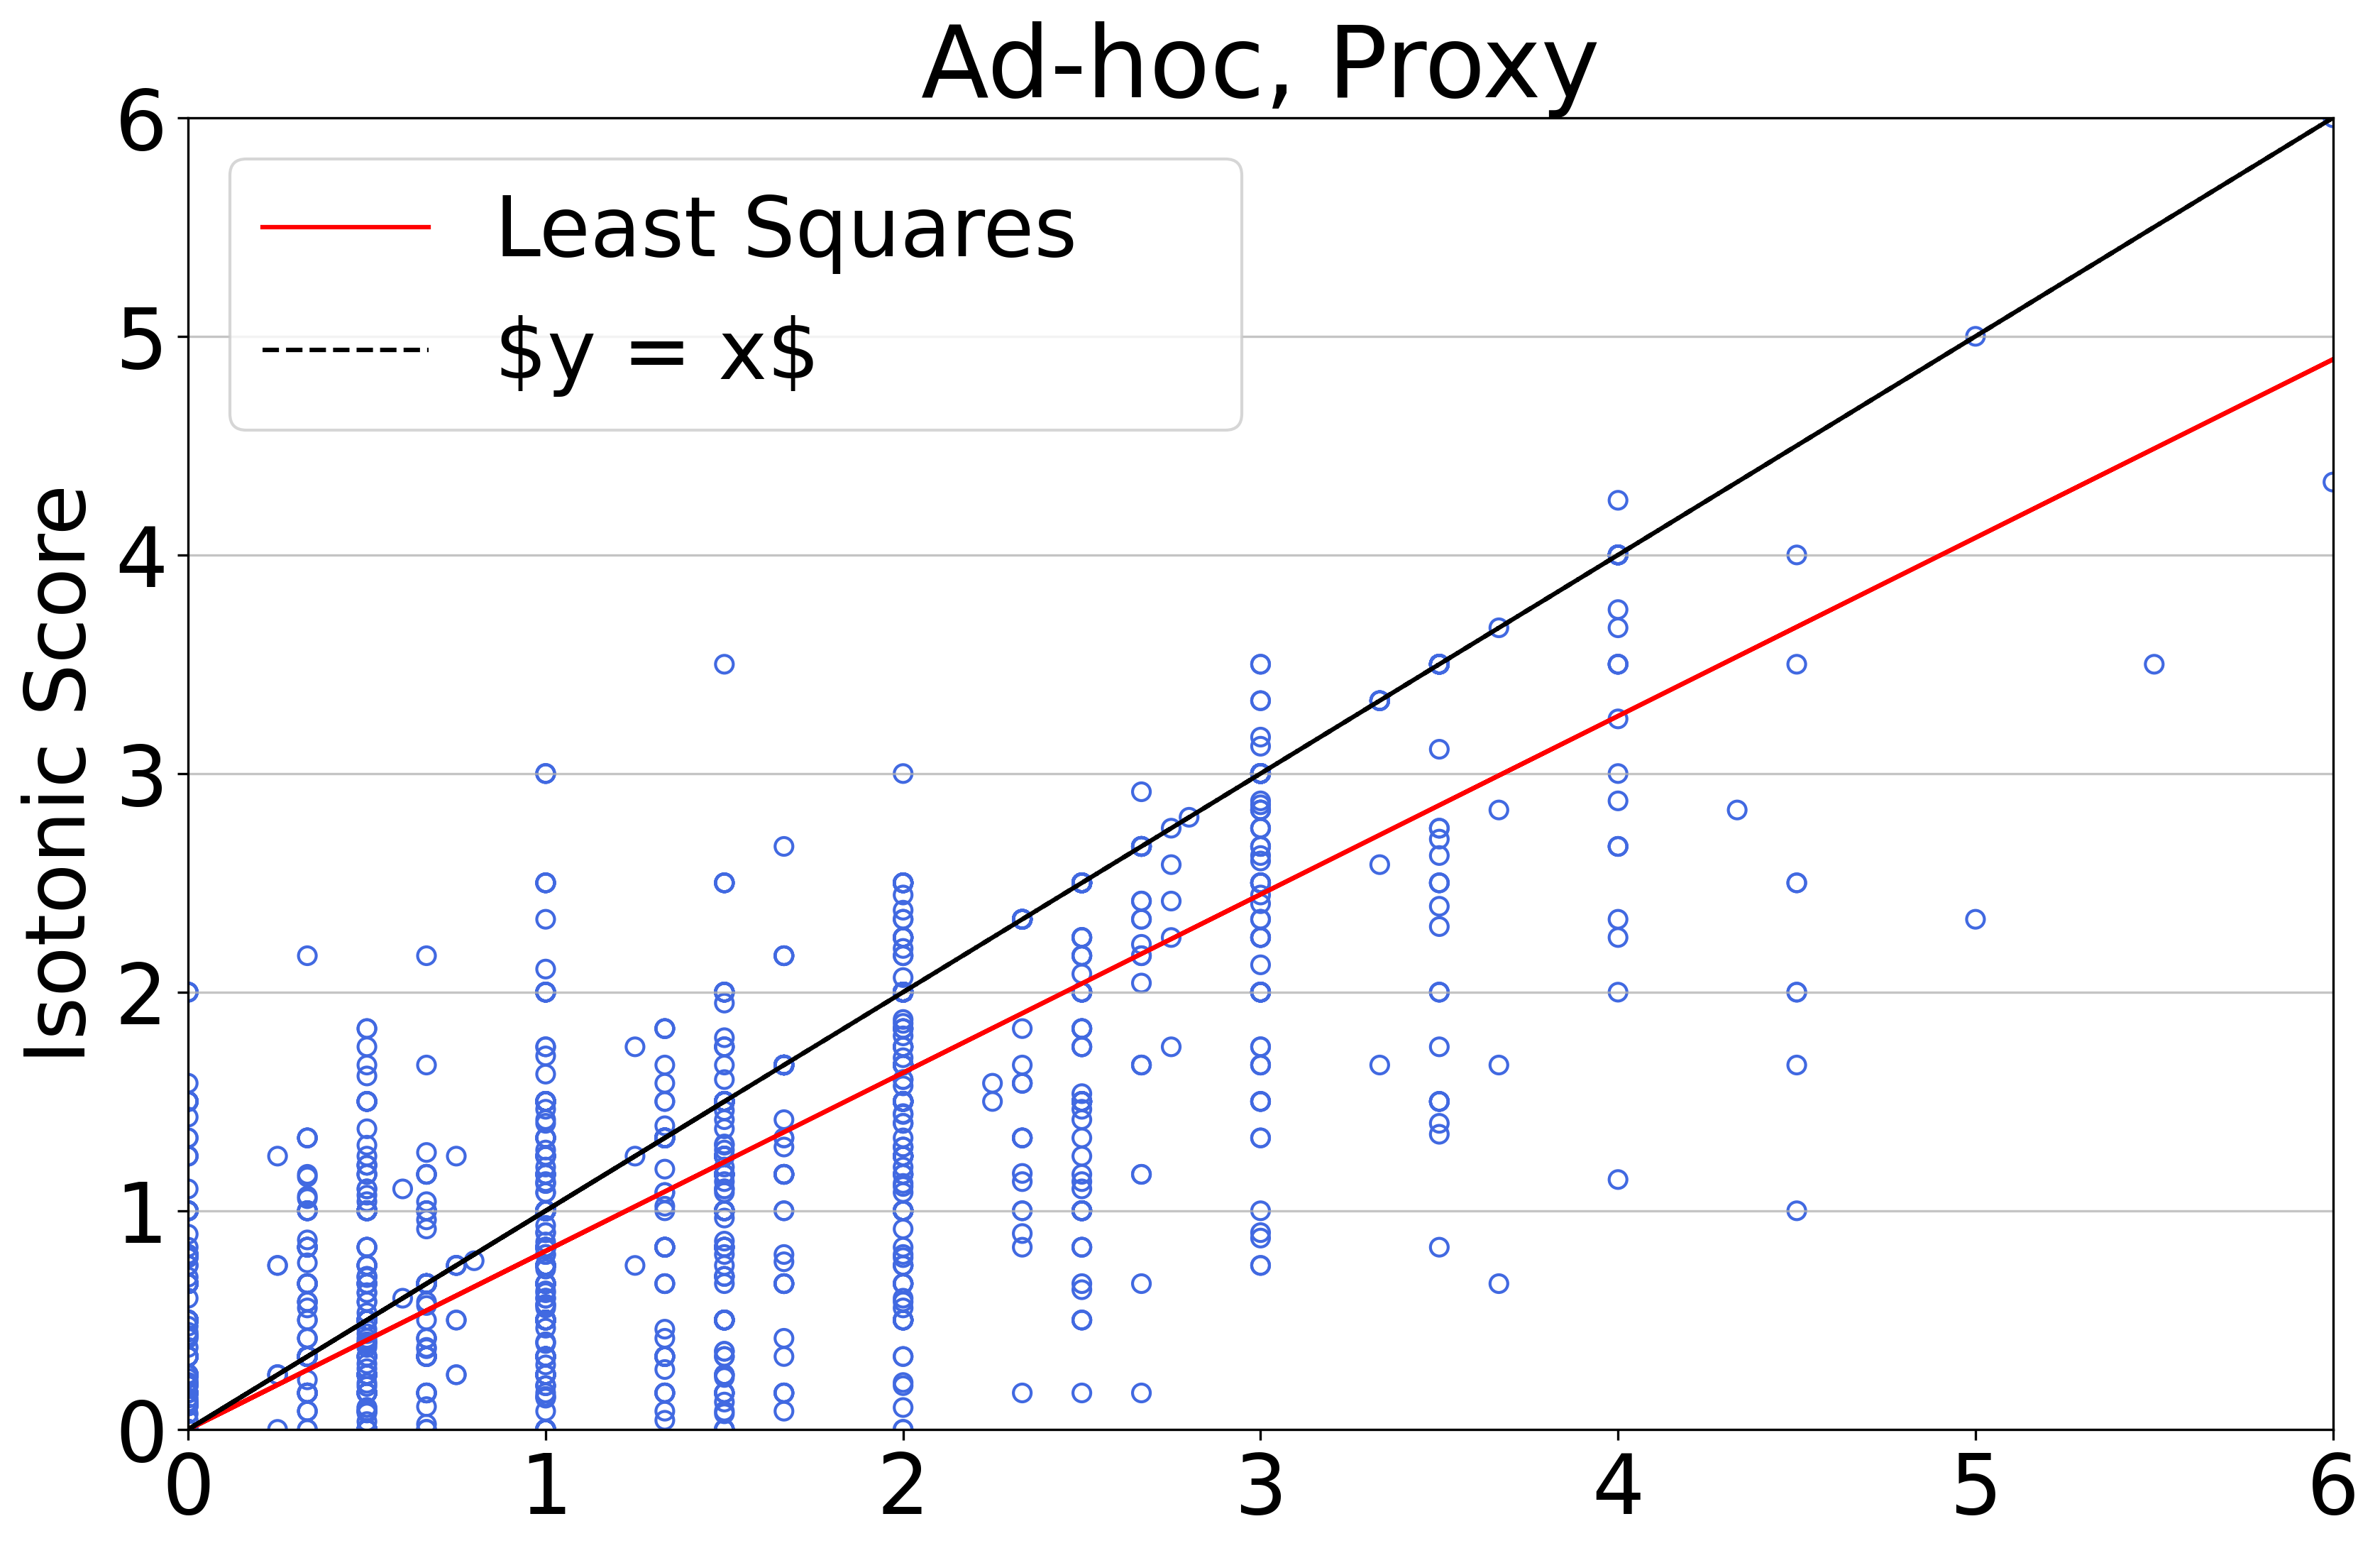

In [9]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 28
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch



# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])



# For each author, list its ranked submissions according to its ranking

author_submission_rank_old = {}

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()

# Loop through every submission
for author in authors:

    author_submission_rank_old[author] = []

    # Extract the rating as sets
    submissions = df[df['author_idx'] == author]['submission_idx'].tolist()

    for i in range(len(submissions)):

        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)

# # print(author_submission_rank_old)


author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

# # print(author_submission_rank_new)


final_submission_list = df['submission_idx'].unique()



submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    # Convert string numbers to float
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating



adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])
# print(adhoc_iso_rating)



submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( (adhoc_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



for i in range(len(True_score_multi_iso)):
  adhoc_diff[i] = (adhoc_diff[i])**(0.5)
  old_diff[i] = (old_diff[i])**(0.5)



old_diff = np.array(old_diff)
adhoc_diff = np.array(adhoc_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, adhoc_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
adhoc_diff = np.array(adhoc_diff)

X = old_diff
Y = adhoc_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(adhoc_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Ad-hoc, Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/adhoc_iso_proxy_regression.svg", bbox_inches='tight')
plt.show()




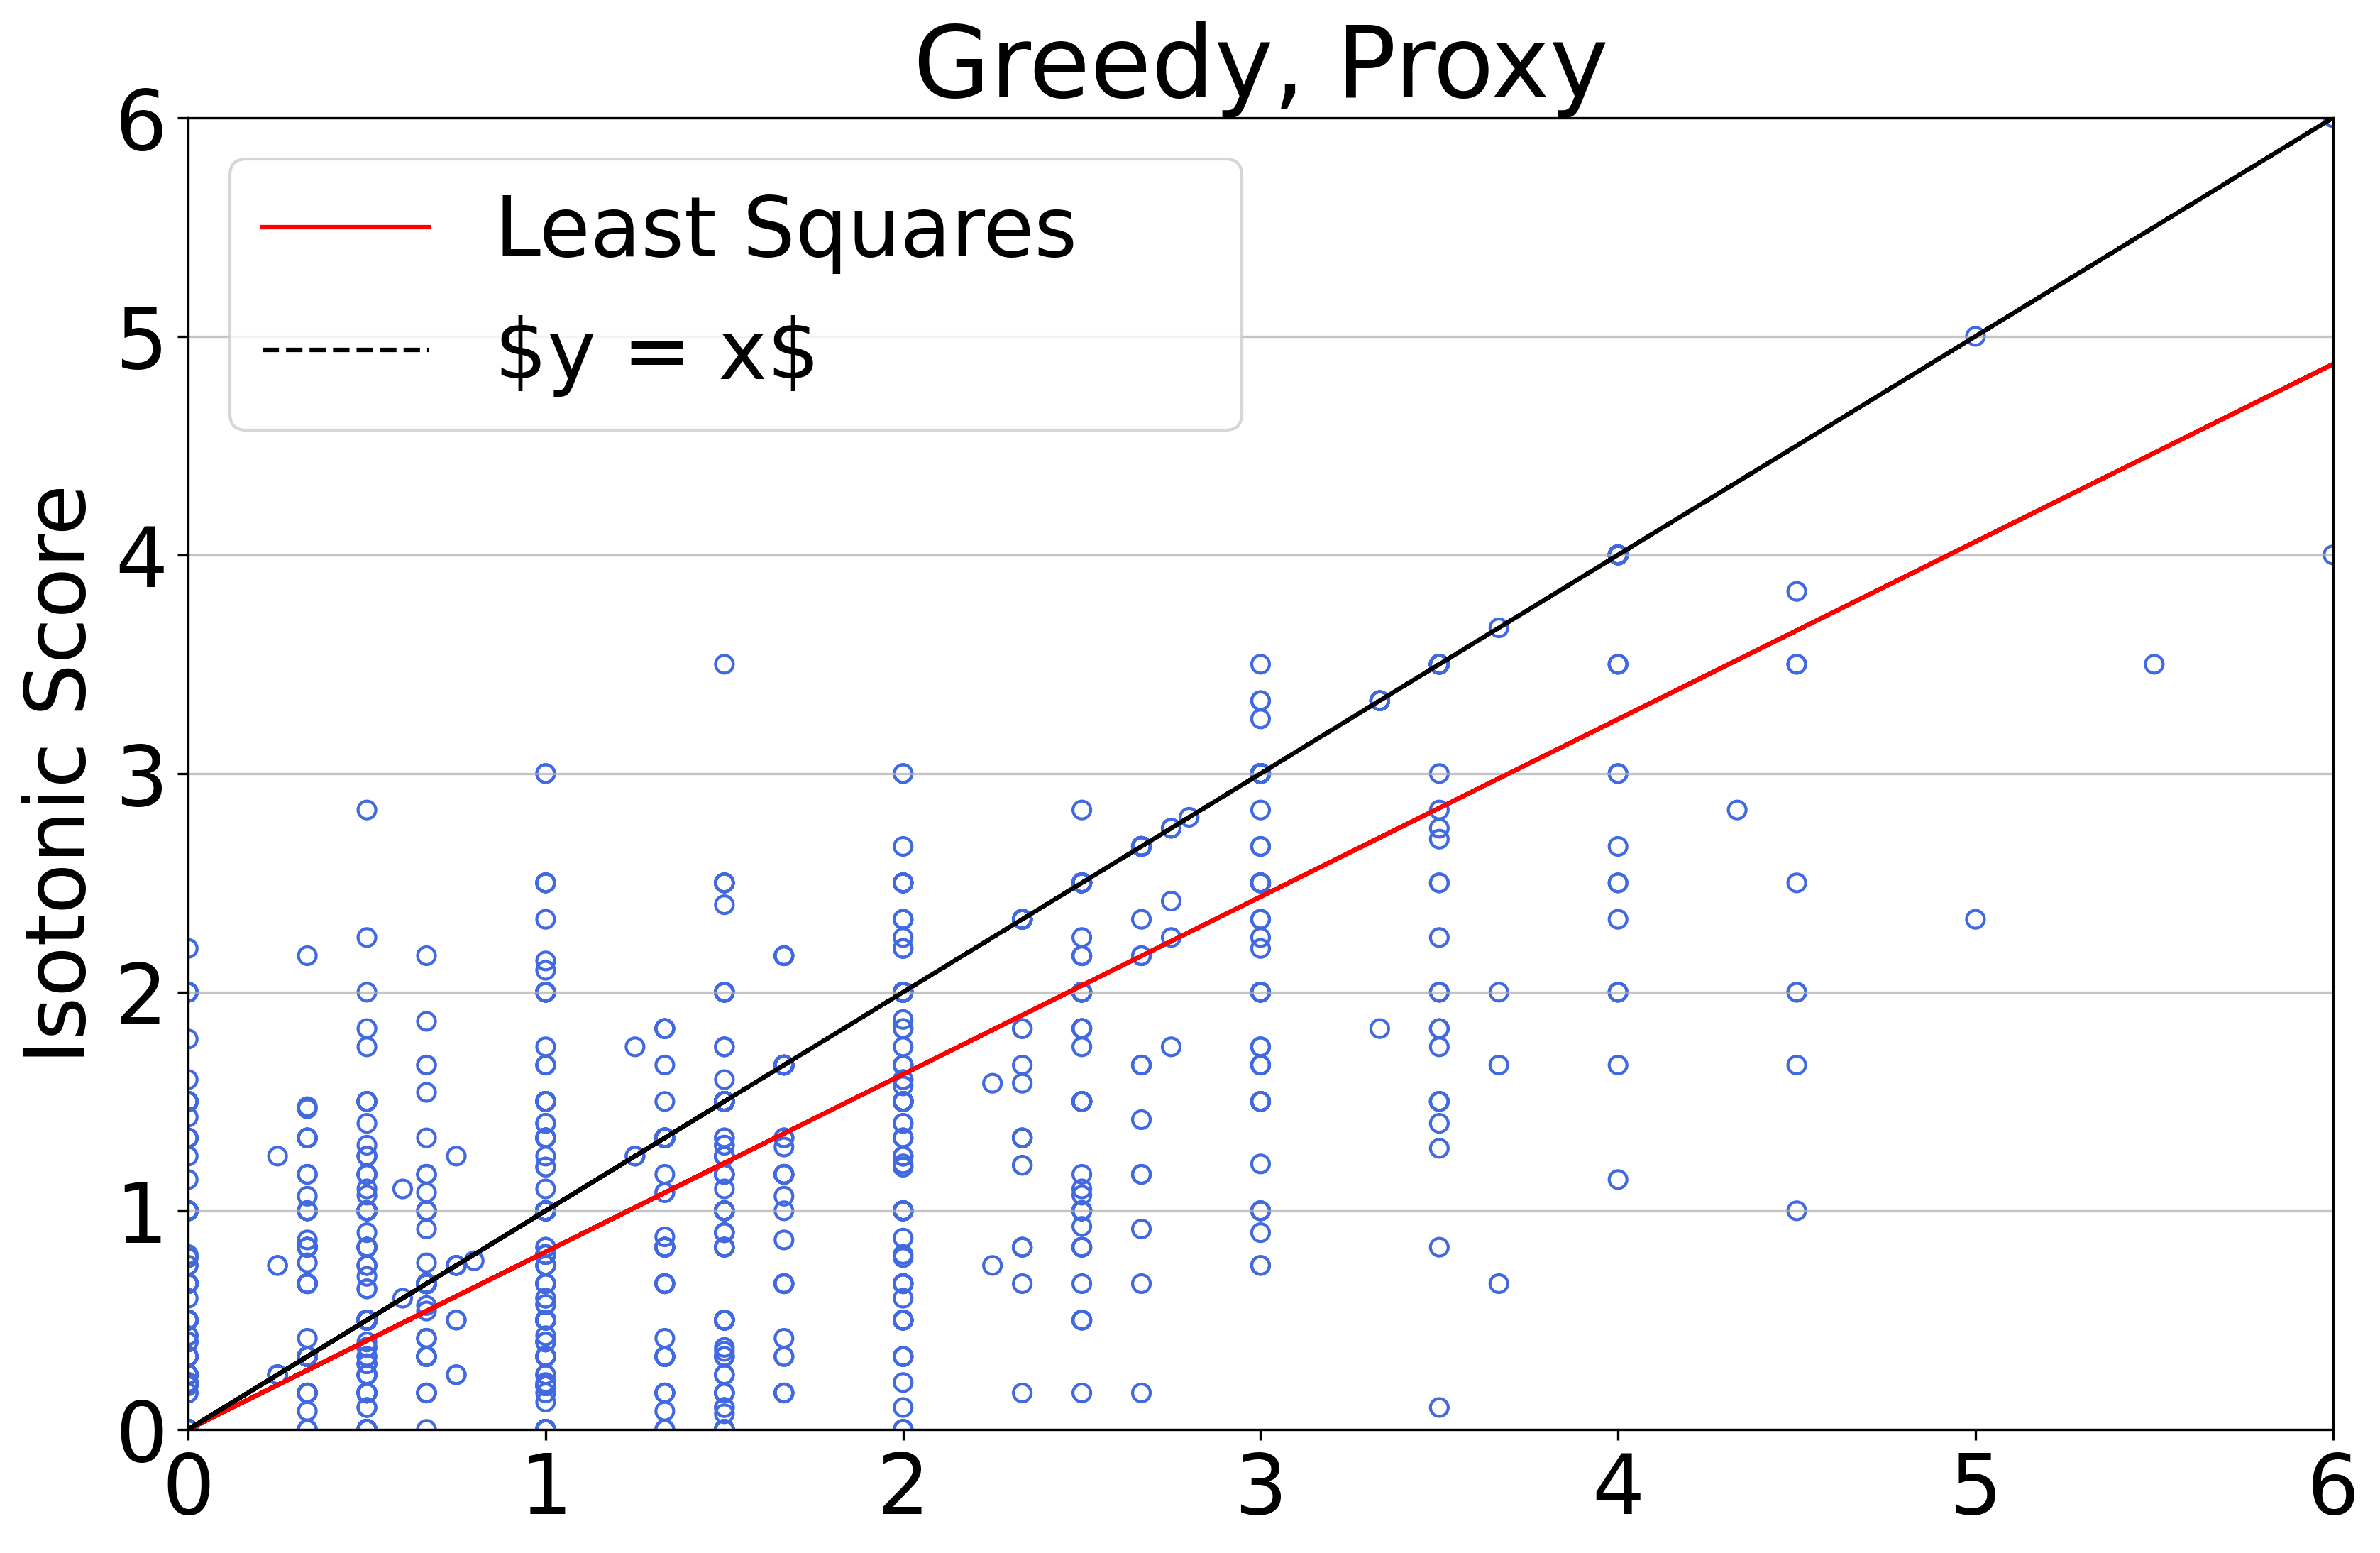

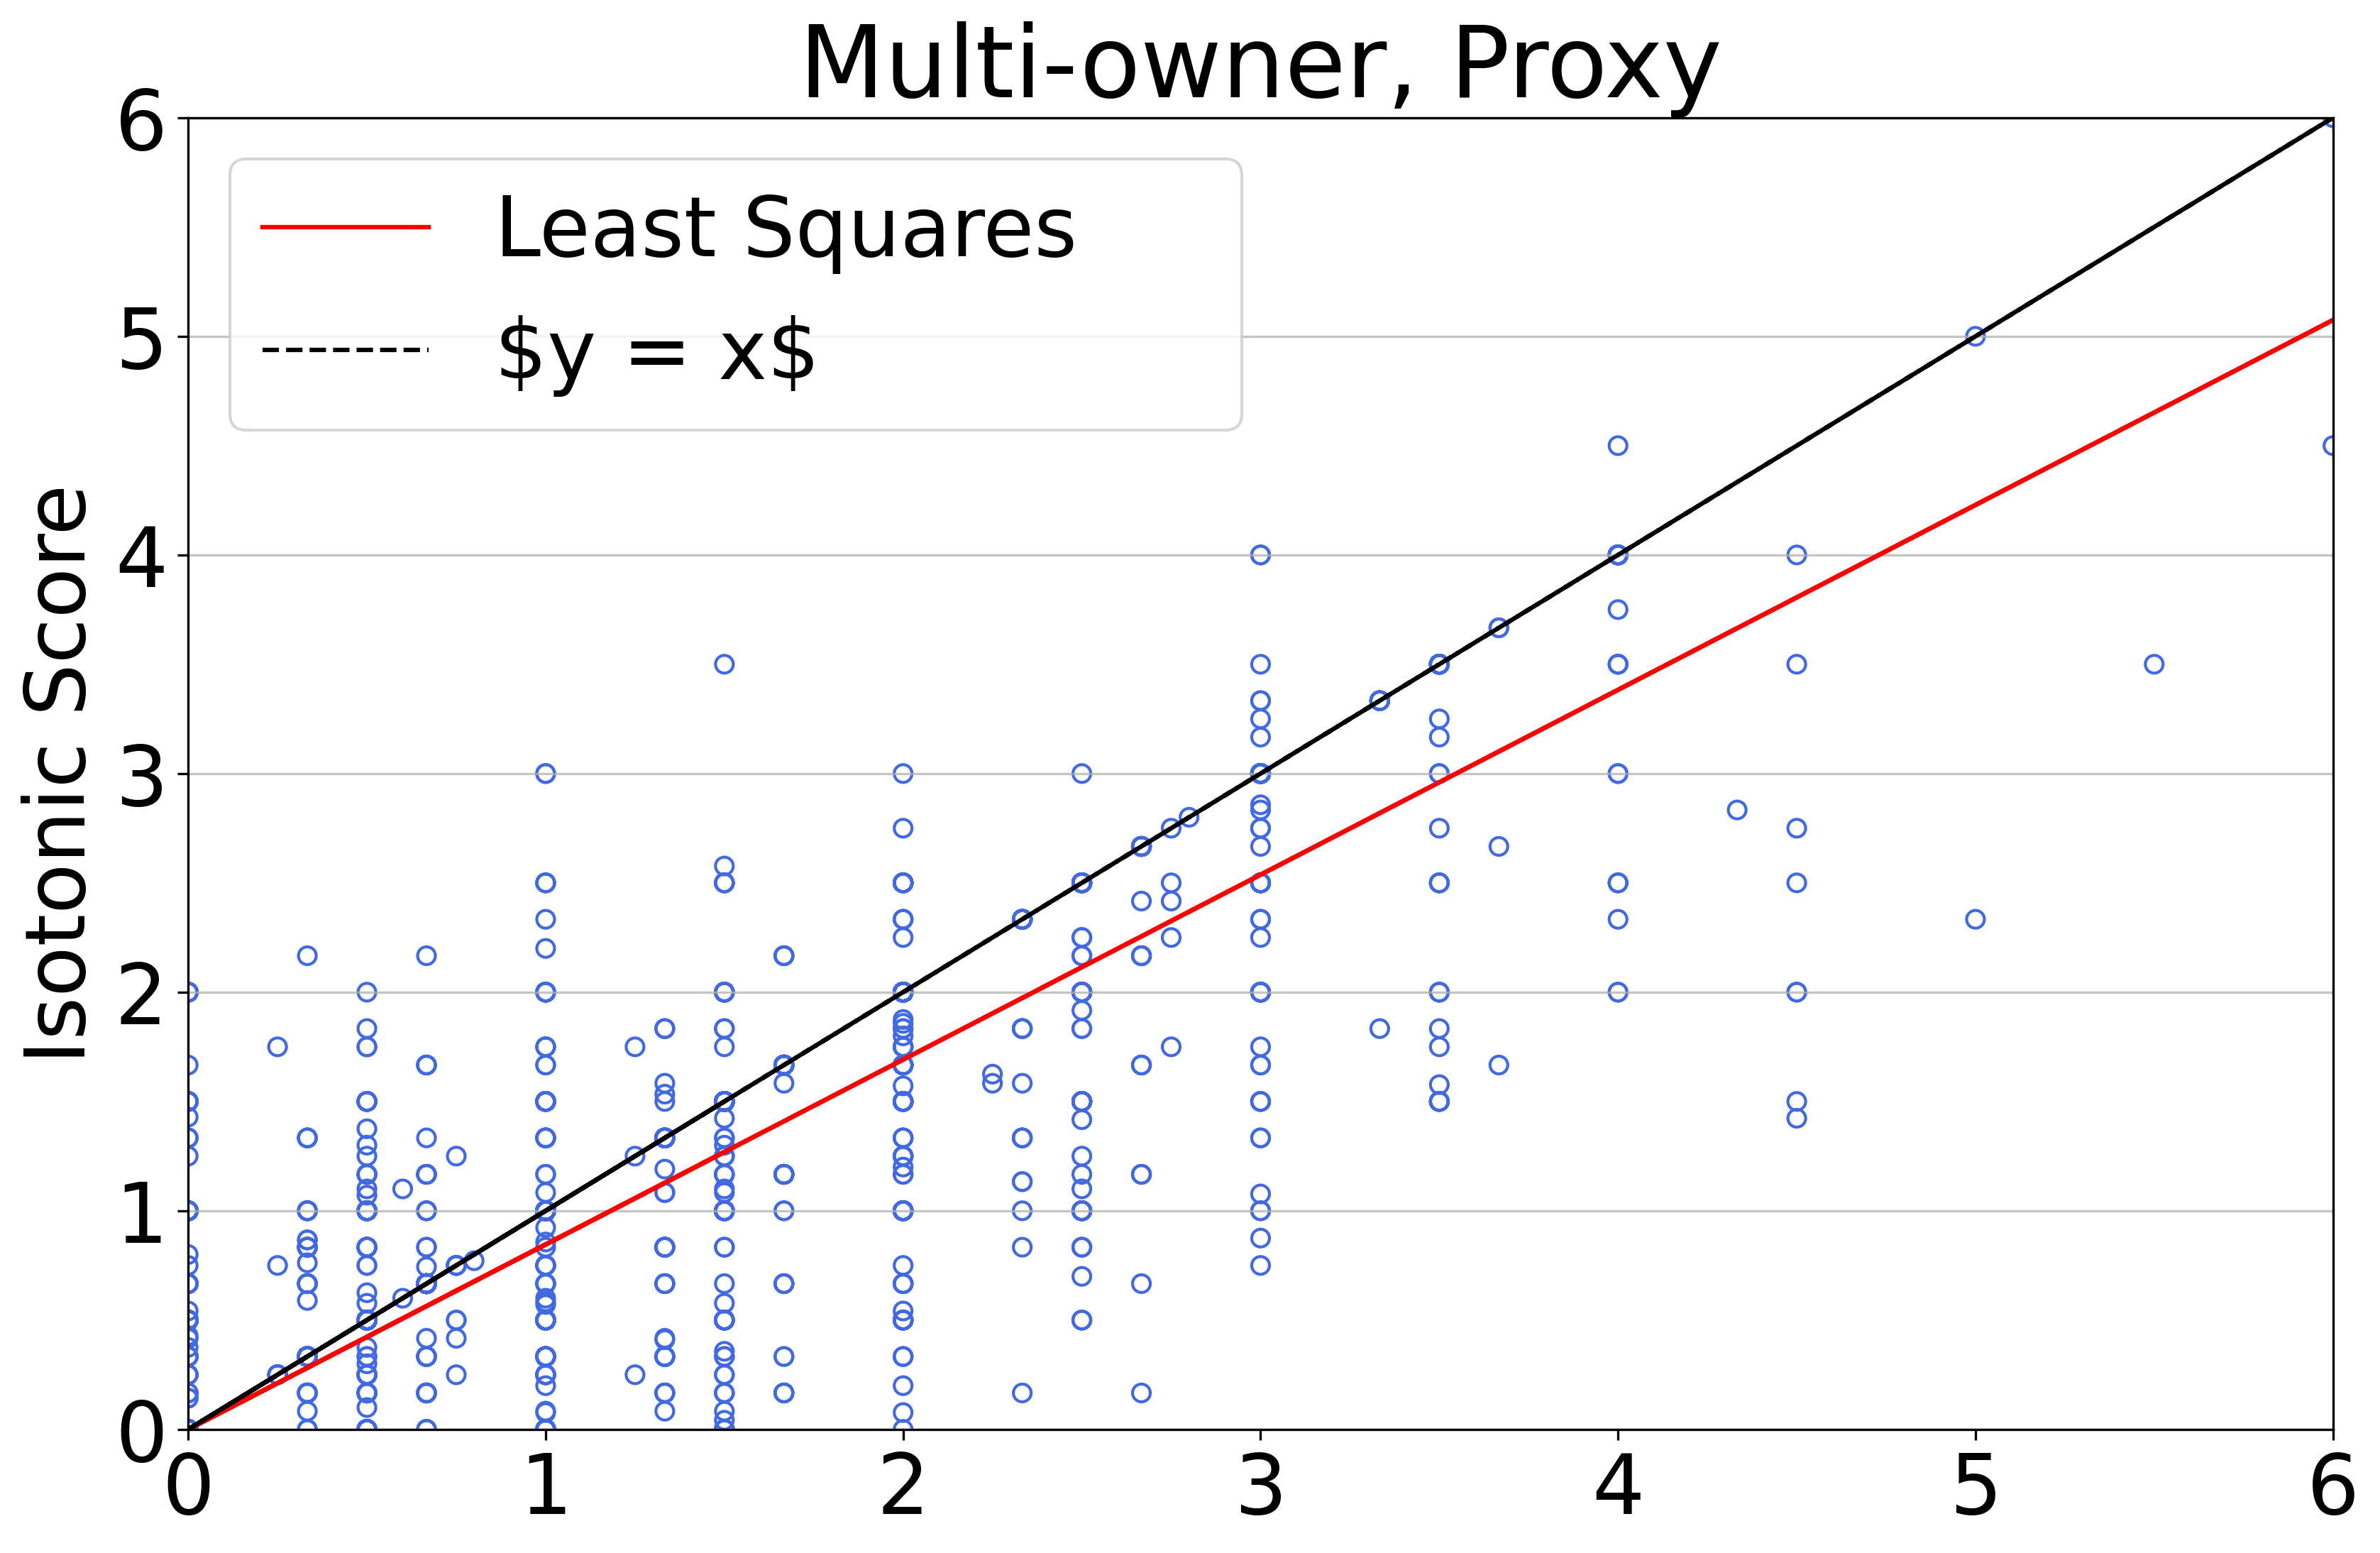

In [10]:

from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch



def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


'''
MULTIOWNER ISOTONIC
'''
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
# Loop through every submission
for author in authors:

    # Extract the rating as sets
    submissionss = df[df['author_idx'] == author]['submission_idx'].tolist()

    # Add the ratings to the results dictionary
    author_submission[author] = submissionss



m_2 = len(author_submission)
n_2 = len(submissions)

'''
authors = [
    {
        paper_idx : ranking,
        ...
    },
    ...
]
'''
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
# # print(partition)
# # print(author_parts)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)

  # # # print the updated dictionary
  # # # print(author_submission_rank_old)



  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
      # # print(ir_rank_pred)

      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

  # # print(author_submission_rank_multi_iso)


  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      # Convert string numbers to float
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]

      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])

      submission_multi_iso_rating[submission] = avg_rating

  # # print(submission_multi_iso_rating)

  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]
#  # print(submission_multi_iso_rating)



multi_iso_rating = []
for i in range(n_2):
  multi_iso_rating.append(calibrated_scores[i])
# # print(multi_iso_rating)



'''
GREEDY ISOTONIC
'''

partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
# # print(partition)
# # print(author_parts)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)

  # # # print the updated dictionary
  # # # print(author_submission_rank_old)



  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
      # # print(ir_rank_pred)

      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

  # # print(author_submission_rank_greedy_iso)


  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      # Convert string numbers to float
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]

      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])

      submission_greedy_iso_rating[submission] = avg_rating

  # # print(submission_greedy_iso_rating)


  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]
#   # print(submission_greedy_iso_rating)



greedy_iso_rating = []
for i in range(n_2):
  greedy_iso_rating.append(calibrated_scores[i])
# # print(greedy_iso_rating)



submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



# print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso, squared=False))
# print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso, squared=False))
## print('Singal Isotonic Mechanism:', mean_squared_error(iso_rating, True_score, squared=False))
# print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))



greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( (greedy_iso_rating[i] - True_score_multi_iso[i])**2 )
  multi_diff.append( (multi_iso_rating[i] - True_score_multi_iso[i])**2  )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )




submission_counts = range(len(greedy_diff))

for i in submission_counts:
  greedy_diff[i] = (greedy_diff[i])**(0.5)
  multi_diff[i] = (multi_diff[i])**(0.5)
  old_diff[i] = (old_diff[i])**(0.5)




old_diff = np.array(old_diff)
greedy_diff = np.array(greedy_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, greedy_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
greedy_diff = np.array(greedy_diff)

X = old_diff
Y = greedy_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(greedy_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Greedy, Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/Greedy_iso_proxy_regression.svg", bbox_inches='tight')
plt.show()






old_diff = np.array(old_diff)
multi_diff = np.array(multi_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, multi_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
multi_diff = np.array(multi_diff)

X = old_diff
Y = multi_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(multi_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Multi-owner, Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/Multi_iso_proxy_regression.svg", bbox_inches='tight')
plt.show()



Isotonic Mechanism for Rating Before Rebuttal and noisy Proxy


ad-hoc

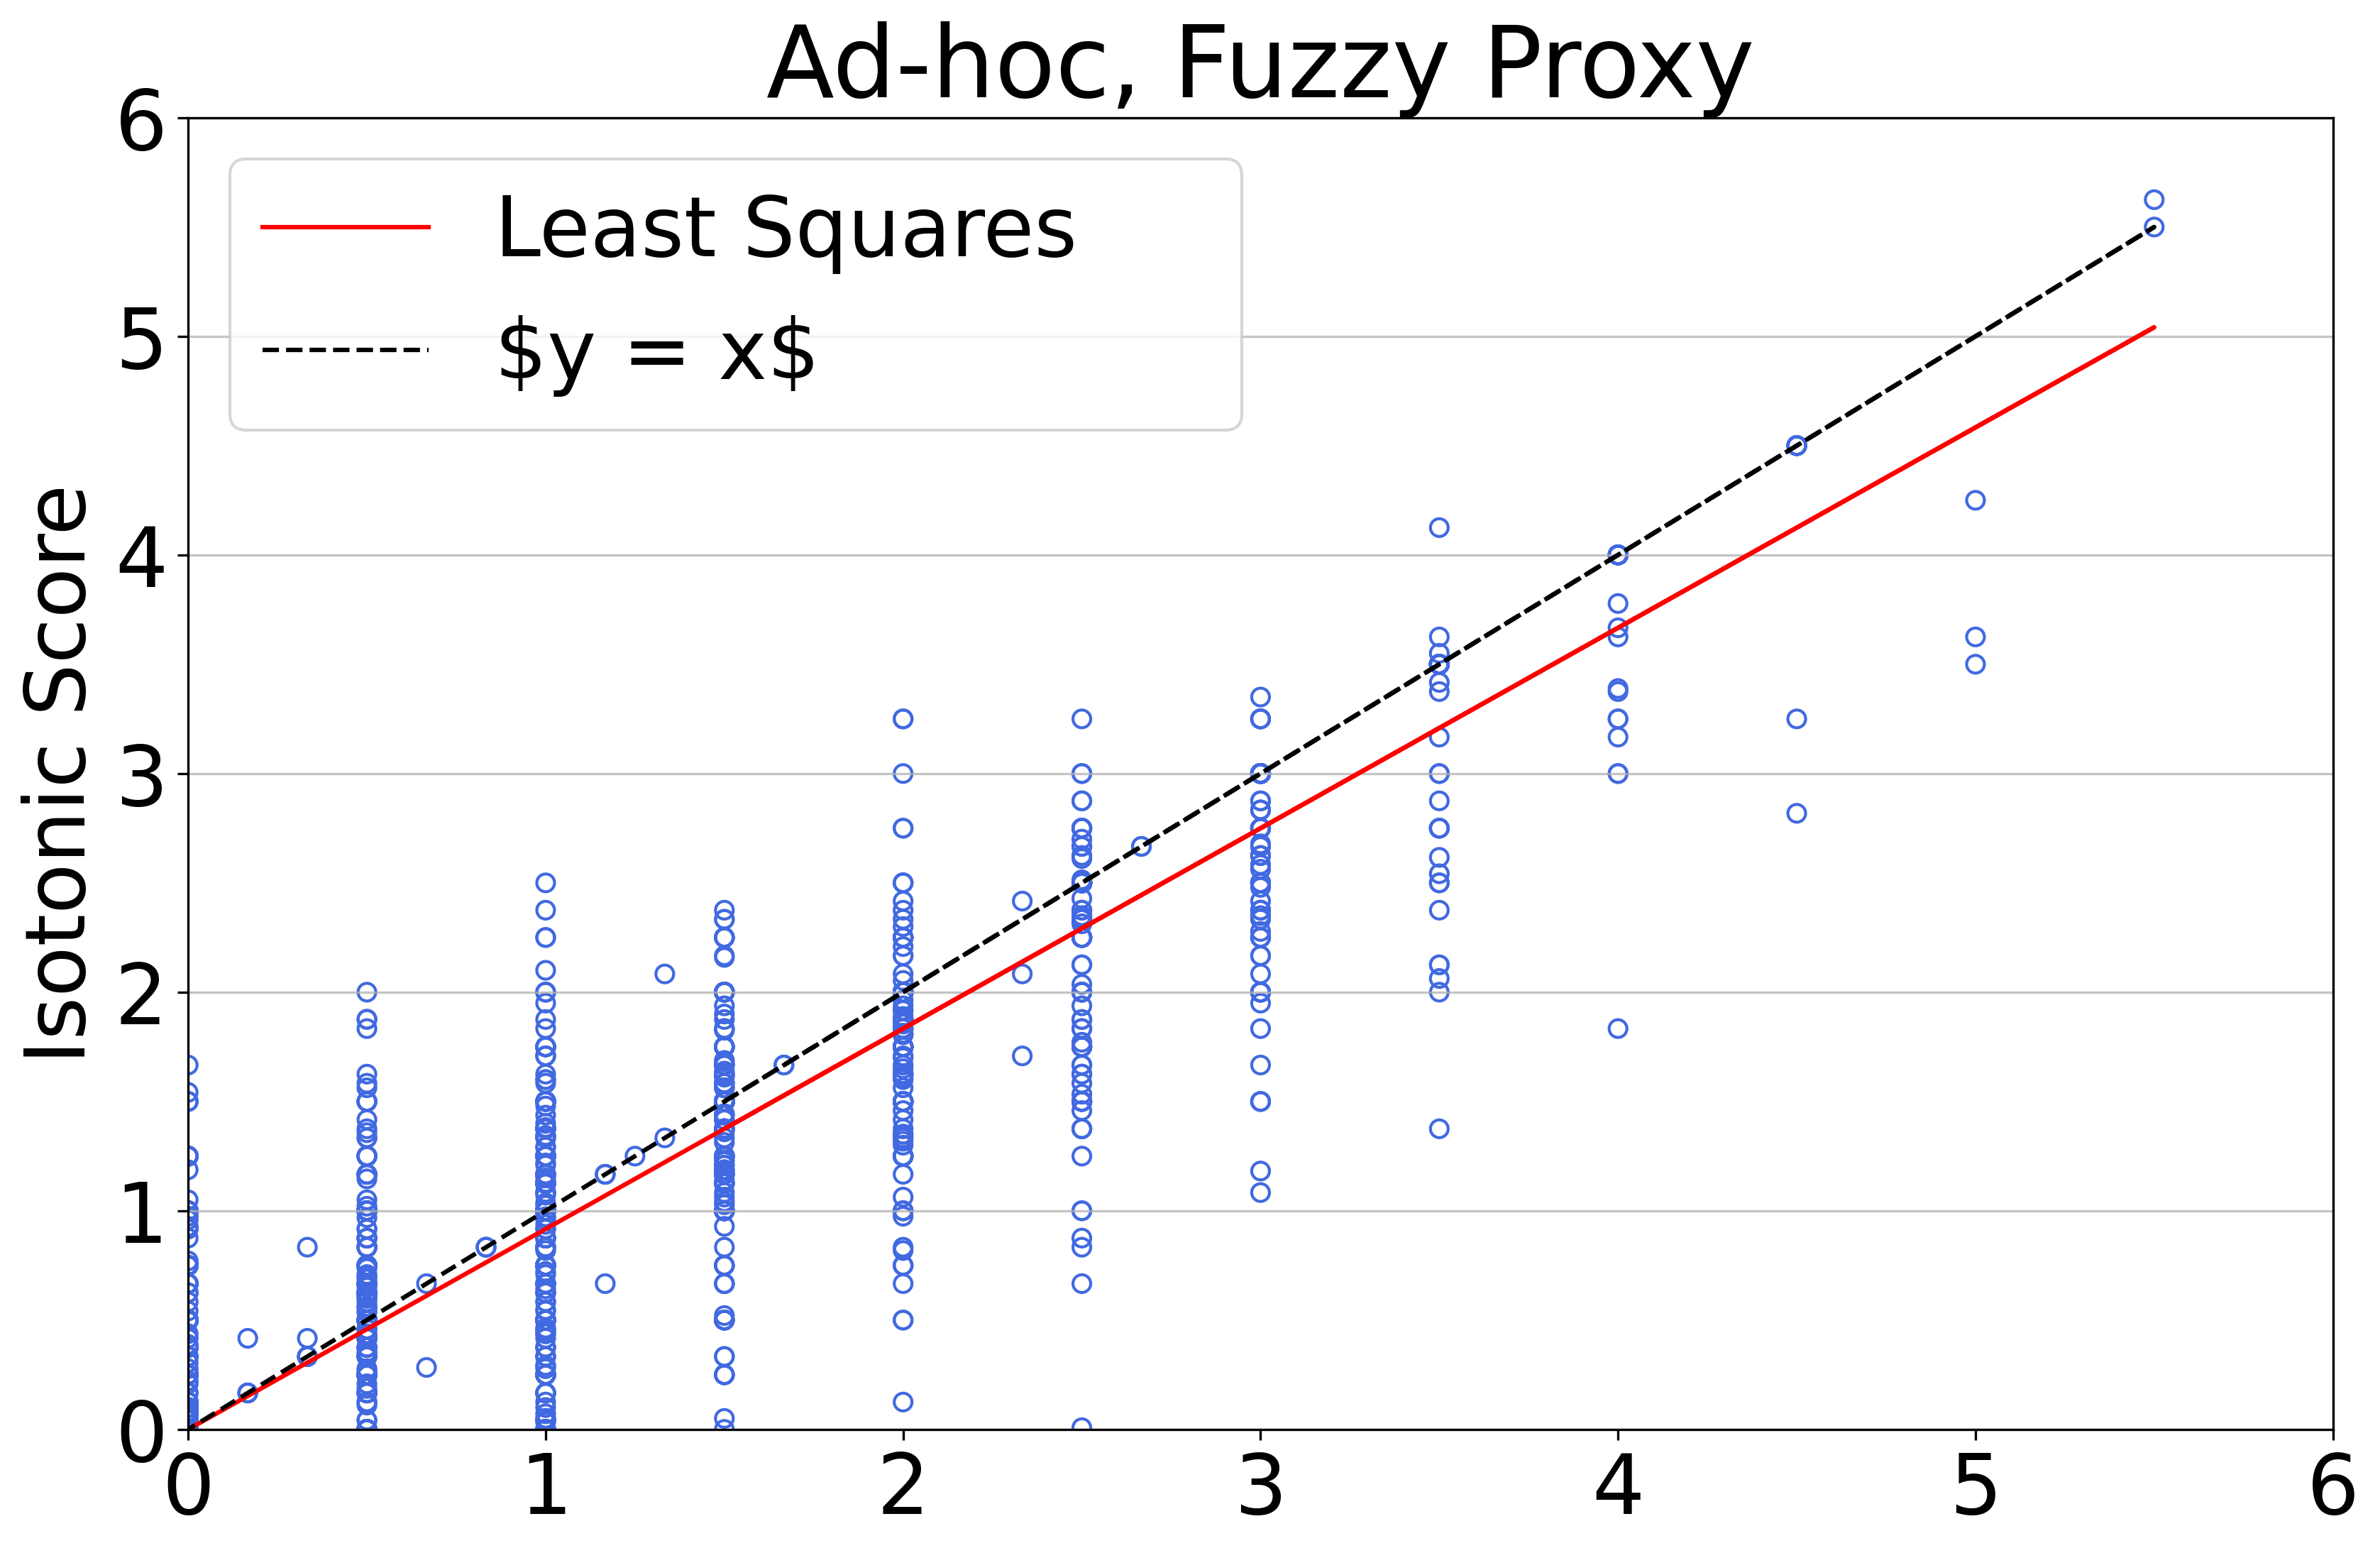

In [11]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch




# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/fuzzy_proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])


# For each author, list its ranked submissions according to its ranking

author_submission_rank_old = {}

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()

# Loop through every submission
for author in authors:

    author_submission_rank_old[author] = []

    # Extract the rating as sets
    submissions = df[df['author_idx'] == author]['submission_idx'].tolist()

    for i in range(len(submissions)):

        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)

# # print(author_submission_rank_old)


author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

# # print(author_submission_rank_new)


final_submission_list = df['submission_idx'].unique()



submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    # Convert string numbers to float
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating



adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])
# print(adhoc_iso_rating)



submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( (adhoc_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



for i in range(len(True_score_multi_iso)):
  adhoc_diff[i] = (adhoc_diff[i])**(0.5)
  old_diff[i] = (old_diff[i])**(0.5)



old_diff = np.array(old_diff)
adhoc_diff = np.array(adhoc_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, adhoc_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
adhoc_diff = np.array(adhoc_diff)

X = old_diff
Y = adhoc_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(adhoc_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Ad-hoc, Fuzzy Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/adhoc_iso_fuzzy_proxy_regression.svg", bbox_inches='tight')
plt.show()




greedy and multiowner

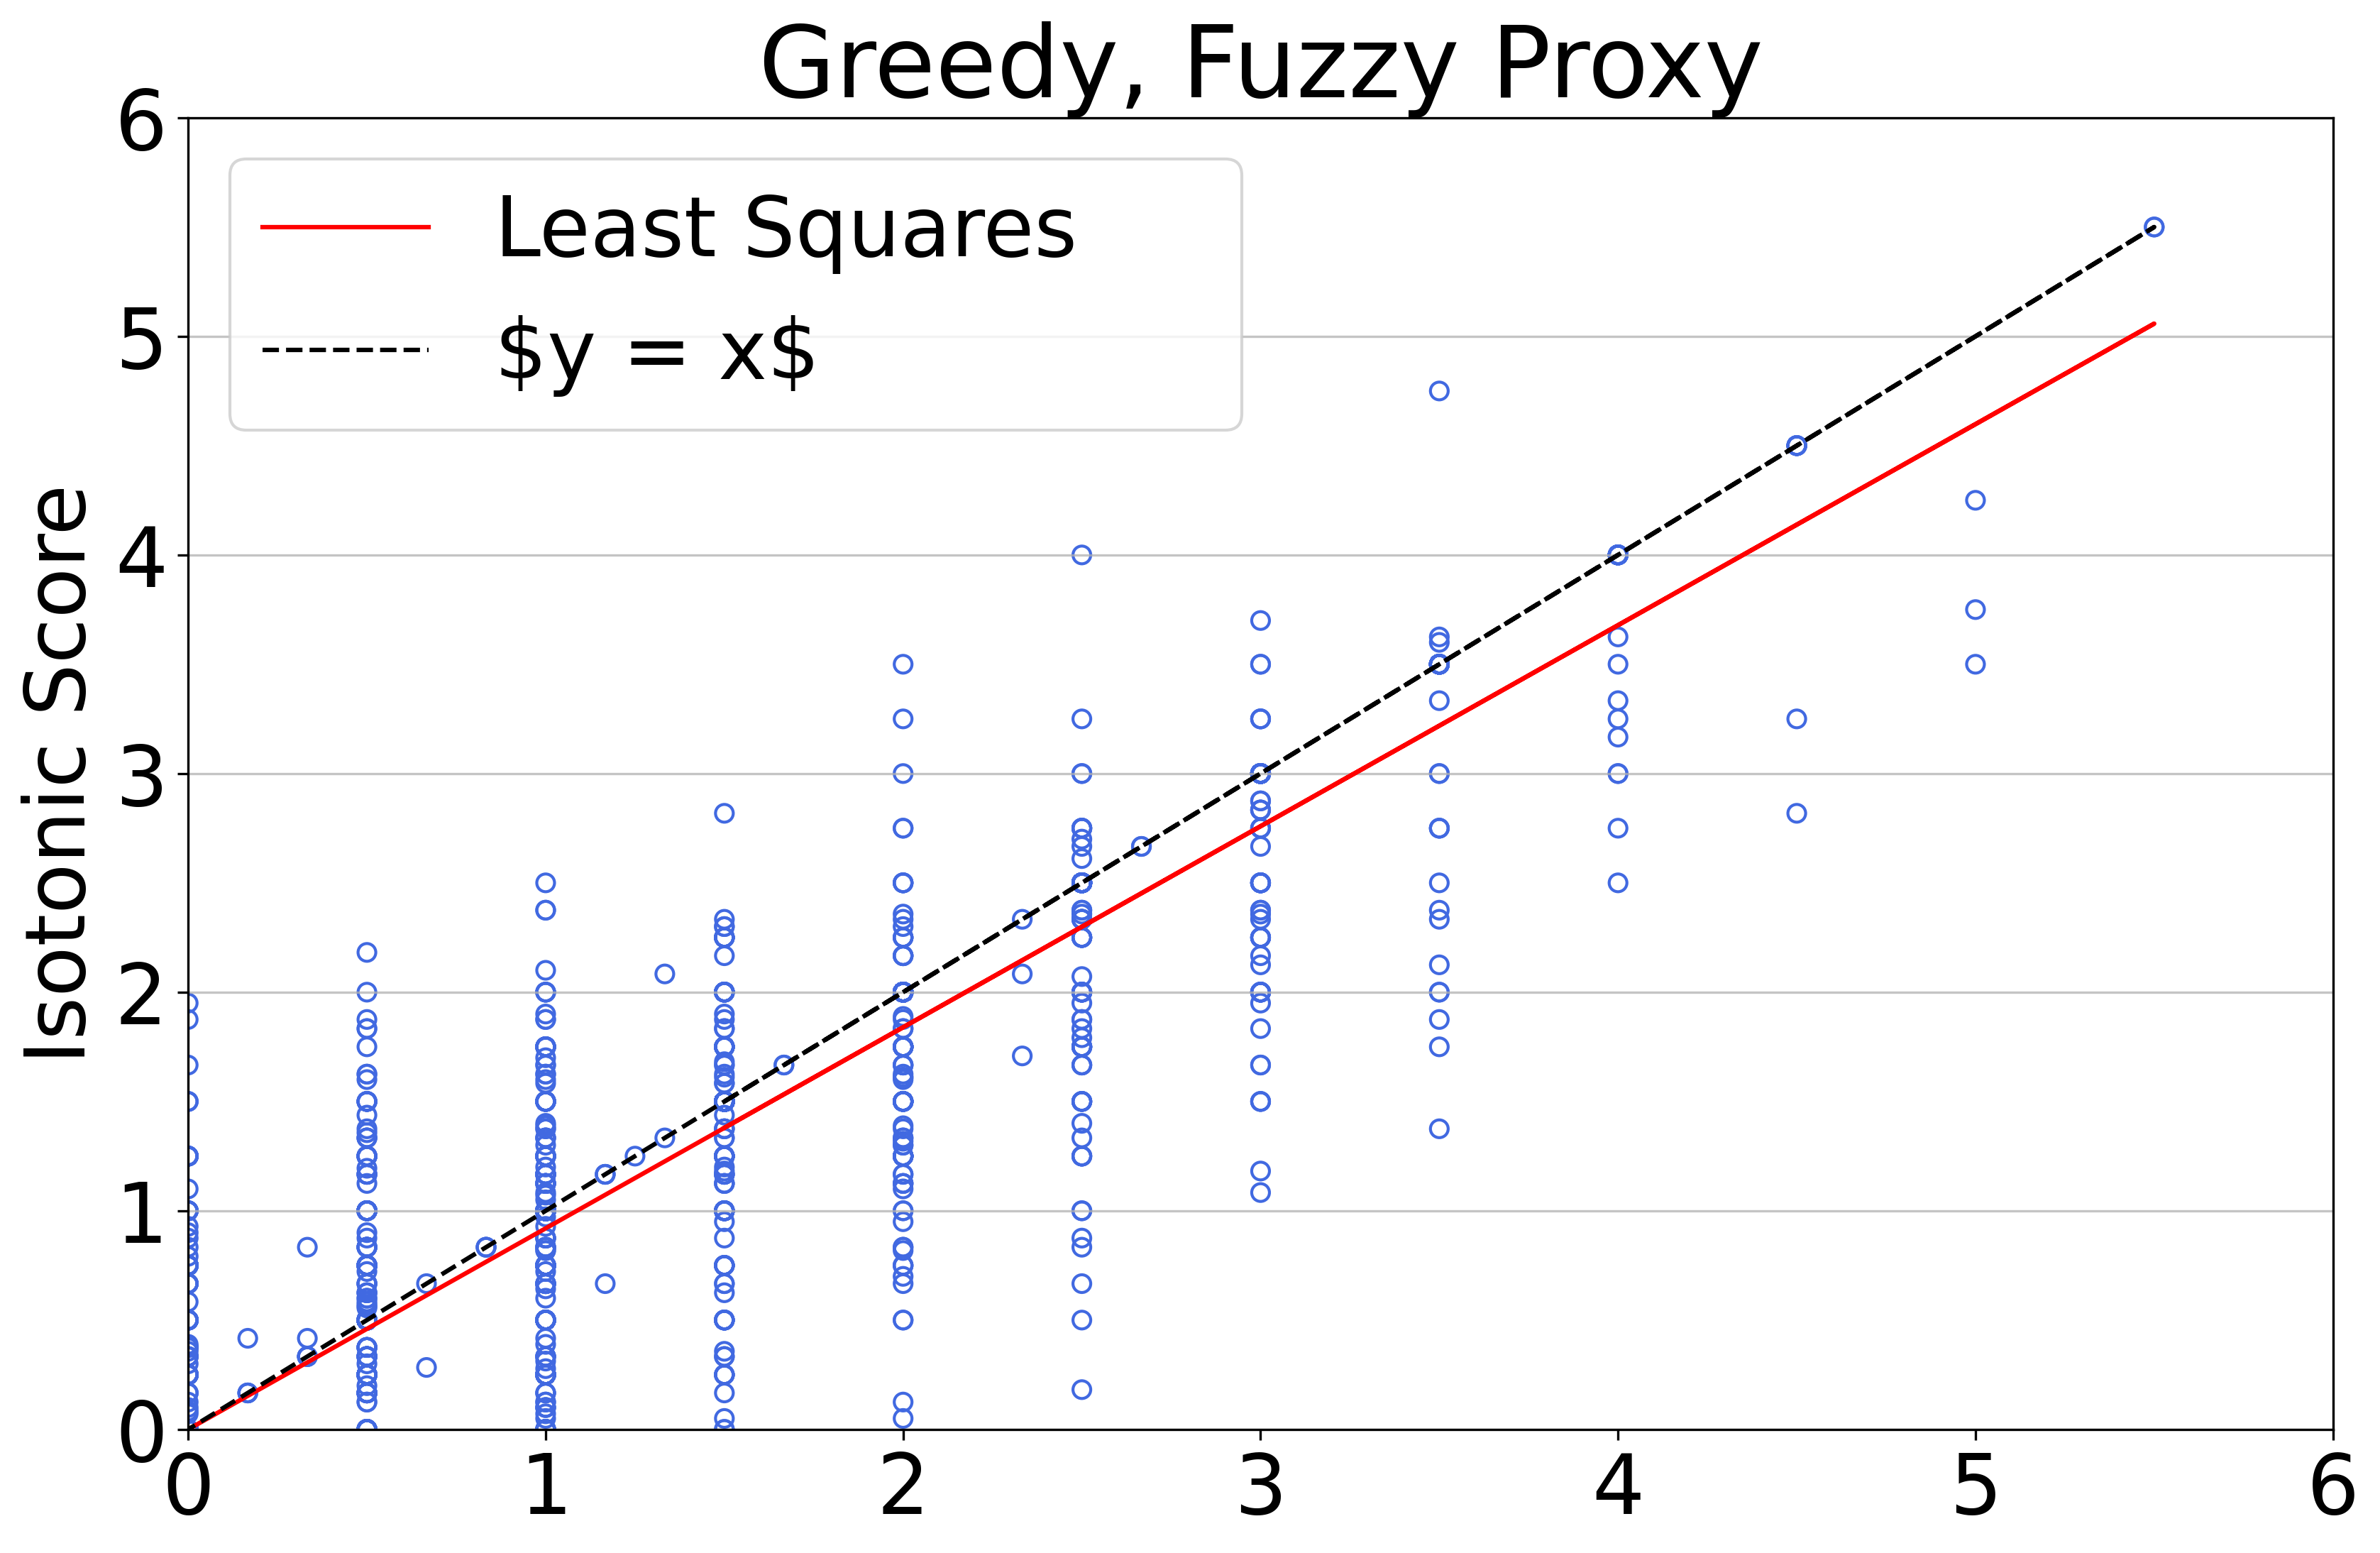

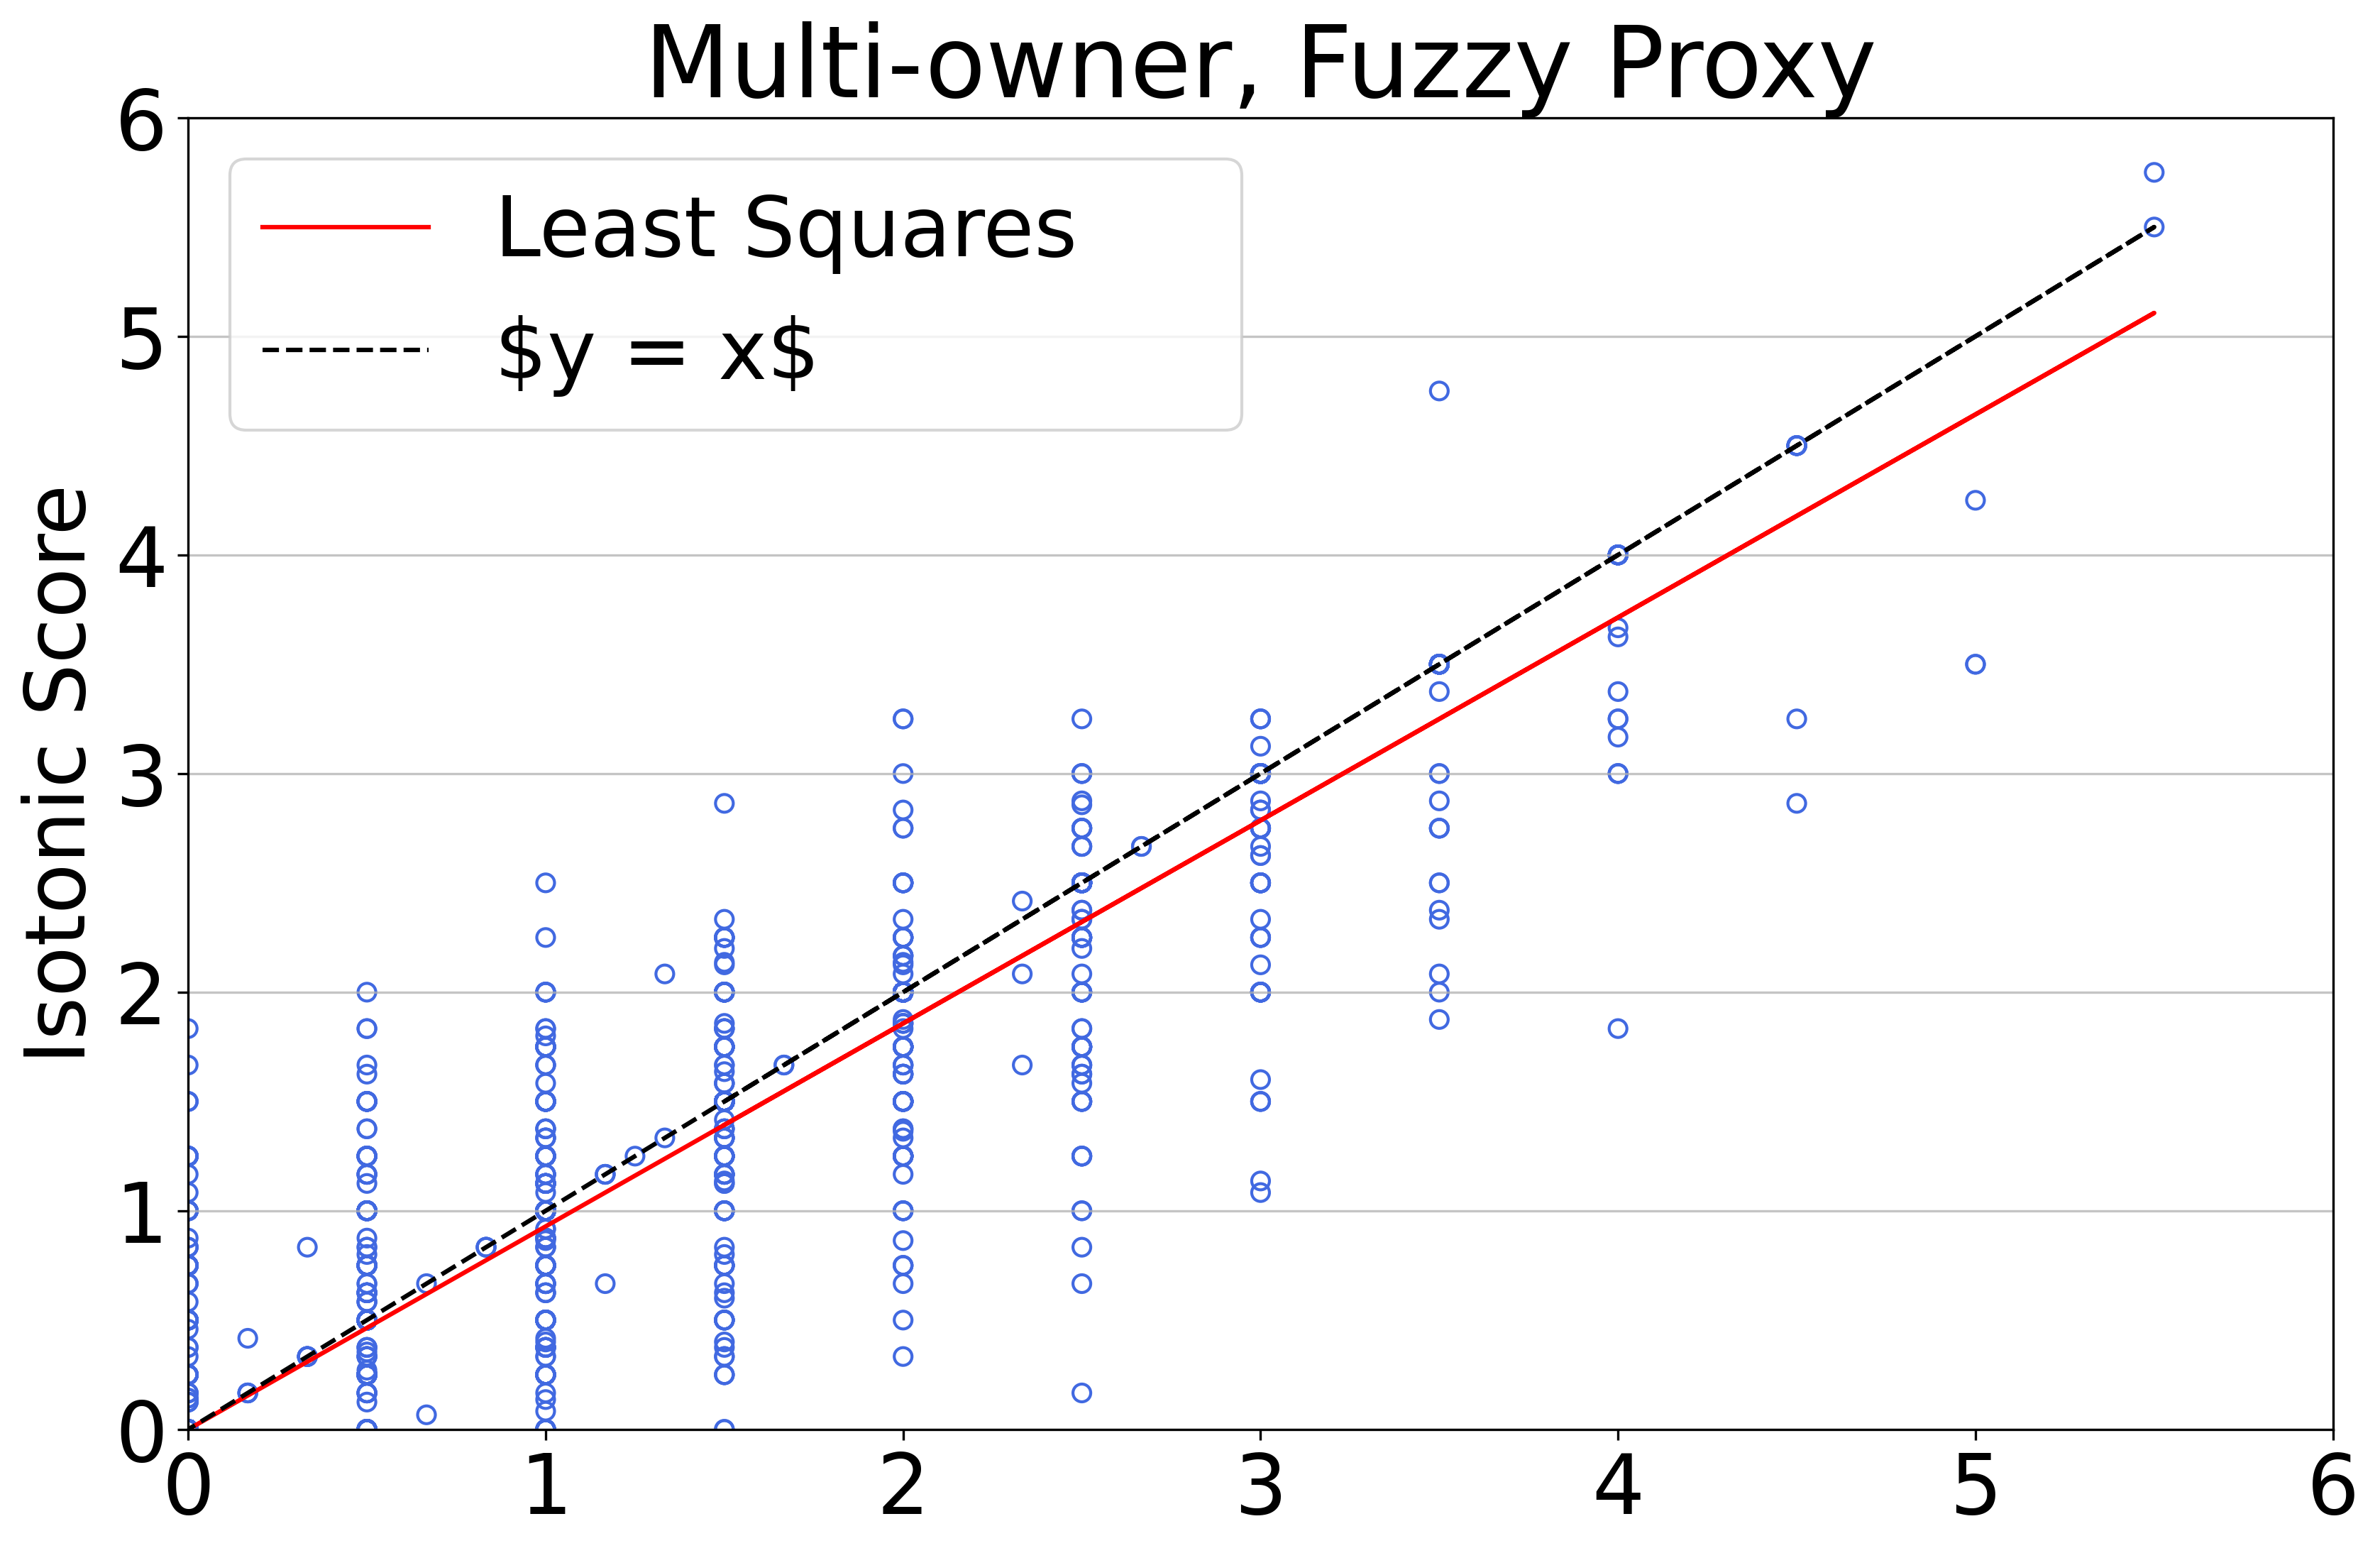

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  8 21:20:29 2023

@author: buxinsu
"""

from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch


def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


'''
MULTIOWNER ISOTONIC
'''
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/Ranking_ICML/fuzzy_proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
# Loop through every submission
for author in authors:

    # Extract the rating as sets
    submissionss = df[df['author_idx'] == author]['submission_idx'].tolist()

    # Add the ratings to the results dictionary
    author_submission[author] = submissionss



m_2 = len(author_submission)
n_2 = len(submissions)

'''
authors = [
    {
        paper_idx : ranking,
        ...
    },
    ...
]
'''
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())

partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
# # print(partition)
# # print(author_parts)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)

  # # # print the updated dictionary
  # # # print(author_submission_rank_old)



  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
      # # print(ir_rank_pred)

      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

  # # print(author_submission_rank_multi_iso)


  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      # Convert string numbers to float
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]

      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])

      submission_multi_iso_rating[submission] = avg_rating

  # # print(submission_multi_iso_rating)

  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]
#  # print(submission_multi_iso_rating)



multi_iso_rating = []
for i in range(n_2):
  multi_iso_rating.append(calibrated_scores[i])
# # print(multi_iso_rating)



'''
GREEDY ISOTONIC
'''

partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)
# # print(partition)
# # print(author_parts)

# run isotonic regression for each partition
calibrated_scores = np.zeros(n_2)

for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue

  paper_part = list(part) # fix the order of papers


  author_submission_rank_old = {}

  # Loop through every submission
  for author in author_part:

    author_submission_rank_old[author] = []

    for i in range(len(paper_part)):

        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()
        rank = rank[0]

        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()
        ratings = ratings[0]

        # Add the ratings to the results dictionary
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))

  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

  author_submission_rank_old = sort_submissions(author_submission_rank_old)

  # # # print the updated dictionary
  # # # print(author_submission_rank_old)



  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
      # # print(ir_rank_pred)

      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))

  # # print(author_submission_rank_greedy_iso)


  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      # Convert string numbers to float
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]

      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])

      submission_greedy_iso_rating[submission] = avg_rating

  # # print(submission_greedy_iso_rating)


  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]
#   # print(submission_greedy_iso_rating)



greedy_iso_rating = []
for i in range(n_2):
  greedy_iso_rating.append(calibrated_scores[i])
# # print(greedy_iso_rating)



submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



# print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso, squared=False))
# print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso, squared=False))
## print('Singal Isotonic Mechanism:', mean_squared_error(iso_rating, True_score, squared=False))
# print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso, squared=False))



greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( (greedy_iso_rating[i] - True_score_multi_iso[i])**2 )
  multi_diff.append( (multi_iso_rating[i] - True_score_multi_iso[i])**2  )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )




submission_counts = range(len(greedy_diff))

for i in submission_counts:
  greedy_diff[i] = (greedy_diff[i])**(0.5)
  multi_diff[i] = (multi_diff[i])**(0.5)
  old_diff[i] = (old_diff[i])**(0.5)



old_diff = np.array(old_diff)
greedy_diff = np.array(greedy_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, greedy_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
greedy_diff = np.array(greedy_diff)

X = old_diff
Y = greedy_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(greedy_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Greedy, Fuzzy Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/Greedy_iso_fuzzy_proxy_regression.svg", bbox_inches='tight')
plt.show()






old_diff = np.array(old_diff)
multi_diff = np.array(multi_diff)


plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(old_diff, multi_diff, facecolors='none', edgecolors='royalblue', marker='o')

old_diff = np.array(old_diff)
multi_diff = np.array(multi_diff)

X = old_diff
Y = multi_diff

# Calculate the slope with intercept = 0
b = np.sum(X * Y) / np.sum(X**2)

# Calculate the standard error of the slope
n = len(X)
y_pred = b * X
residuals = Y - y_pred
RSS = np.sum(residuals**2)
s_b = np.sqrt(RSS / (n-1)) / np.sqrt(np.sum( (X - np.mean(X))**2))

# Calculate the t-statistic
t_stat = (b - 1) / s_b

# Calculate the p-value
df = len(multi_diff) - 1
p_value = stats.t.sf(np.abs(t_stat), n-2)
p_value = format(p_value, ".1e")

# print(f"Slope: {b}")
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")

# Calculate the y-values for the line of best fit
line_of_best_fit = b * old_diff

# Plot the line of best fit with intercept 0
plt.plot(old_diff, line_of_best_fit, label='Least Squares     ', color='red')

# Plot the regression line
plt.plot(old_diff, old_diff, color='black', label='\$y = x\$', linestyle='dashed')

# Add labels and legend
# plt.xlabel(f"Raw")
plt.ylabel('Isotonic Score')

# Show the legend
plt.legend()
plt.xlim(0, 6)
plt.ylim(0, 6)

plt.grid(axis='y', alpha=0.75)
plt.title('Multi-owner, Fuzzy Proxy')
plt.savefig("/content/drive/MyDrive/Research/Ranking_ICML/Figures/Multi_iso_fuzzy_proxy_regression.svg", bbox_inches='tight')
plt.show()



